In [5]:
import os
import shutil
import numpy as np
import pandas as pd
import tensorflow as tf
import keras

from functools import partial

from tqdm import tqdm

from matplotlib import pyplot as plt

from keras import backend as K
from keras.preprocessing import image
from keras.applications import VGG19, InceptionV3
from keras.preprocessing.image import ImageDataGenerator
from keras import optimizers
from keras.models import Sequential
from keras.layers import Dropout, Dense, Flatten, GlobalAveragePooling2D, GlobalMaxPooling2D
from keras.callbacks import Callback, LearningRateScheduler

from sklearn.metrics import accuracy_score, f1_score

from tensorflow import train


In [24]:
##################################
#           PARAMETERS
##################################

# These are some defaults that might change
# according to chosen architecture

train_dir = 'data/train/'
test_dir = 'data/test/'
val_dir = 'data/val/'

# image_size MUST AGREE with receptive_field
params = {
    'image_size': (299, 299),
    'receptive_field': (299, 299, 3),
    'batch_size': 32,
    'n_classes': 83,
    'n_epochs': 15
}


In [25]:
# Because net was trained for imagenet, I should normalise the input using:
# mean = [0.485, 0.456, 0.406] and std = [0.229, 0.224, 0.225]
# However, results came even without it, so I am sticking to no normalisation
# until I find it necessary.

def max_square_crop(image, location='random'):
    '''
    Returns a square crop of maximum dimensions within _image_.
    The crop location can be 'random' (default) or 'centre'.
    Yep, centre, fuck America.
    '''
    # Input is a numpy 3D array
    height, width, _ = image.shape
    side = np.min((height, width))
    h_band = height - side
    w_band = width - side
    
    if location == 'centre':
        raise NotImplementedError('Sorry, central crop not implemented yet. Yes, lazy me.')

    rand_row = np.random.randint(0, h_band + 1)
    rand_col = np.random.randint(0, w_band + 1)
    
    square_crop = image[rand_row:(rand_row + side),
                        rand_col:(rand_col + side), :]
    
    return square_crop


preproc_crop = partial(max_square_crop, location='random')

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest',
    zoom_range=0.2,
    preprocessing_function=preproc_crop
)

validation_datagen = ImageDataGenerator(
    rescale=1./255,
    preprocessing_function=preproc_crop
)

if (os.getcwd()[-4:] != 'lab4'):
    os.chdir('..')

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=params['image_size'],
    batch_size=params['batch_size'],
    class_mode='categorical'
)

validation_generator = validation_datagen.flow_from_directory(
    val_dir,
    target_size=params['image_size'],
    batch_size=params['batch_size'],
    class_mode='categorical'
)

Found 8300 images belonging to 83 classes.
Found 6022 images belonging to 83 classes.


## The main classifier

In [26]:
net = InceptionV3(
    include_top=False,
    weights='imagenet',
    input_shape=params['receptive_field']
)

In [ ]:
net.summary()

In [27]:
# Disable training in all but the last 4 layers
for layer in net.layers:
    layer.trainable = False

#for layer in net.layers[-17:]:
#    layer.trainable = True

# And check it
#for layer in net.layers:
#    print(layer, layer.trainable)


The previous model added the following layers:

``` python
    InceptionV3()
    Flatten()
    Dropout(0.25)
    Dense(n_classes, activation='softmax')
```

In [28]:
model = Sequential()

model.add(net)
model.add(GlobalAveragePooling2D(name='global_avg_pool'))
model.add(Dense(1024, activation='relu'))
model.add(Dense(params['n_classes'], activation='softmax', name='classifier'))

model.summary()


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_v3 (Model)         (None, 8, 8, 2048)        21802784  
_________________________________________________________________
global_avg_pool (GlobalAvera (None, 2048)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 1024)              2098176   
_________________________________________________________________
classifier (Dense)           (None, 83)                85075     
Total params: 23,986,035
Trainable params: 2,183,251
Non-trainable params: 21,802,784
_________________________________________________________________


In [34]:
#optimizer = optimizers.SGD(lr=params['learning_rate'], momentum=0.9, decay=1e-6)
optimizer = optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=1e-6, amsgrad=False) # try with decay like 1e-5

#tf_optimizer = train.RMSPropOptimizer(0.045, decay=0.9, momentum=0.9, epsilon=1.0)
#optimizer = optimizers.TFOptimizer(tf_optimizer)

model.compile(
    loss='categorical_crossentropy',
    optimizer=optimizer,
    metrics=['categorical_accuracy']
)


In [ ]:
'''
params['learning_rate'] = 0.045
optimizer = optimizers.RMSprop(decay=0.9, epsilon=1.0)
'''

def exp_decay(epoch):
   lr = 0.045 * np.exp(- 0.94 * epoch)
   return lr

def step_decay(epoch):
    initial_lrate = 0.1
    drop = 0.5
    epochs_drop = 10.0
    lr = initial_lrate * math.pow(drop, math.floor((epoch)/epochs_drop))
    return lr

def step_exp_decay(epoch):
   lr = 0.045 * np.exp(- 0.94 * np.floor(epoch / 2))
   return lr

lr_scheduler = LearningRateScheduler(step_exp_decay)

# records learning rate per epoch
class LRHistory(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.losses = []
        self.lr = []
        
    def on_epoch_end(self, epoch, logs={}):
        self.losses.append(logs.get('loss'))
        self.lr.append(step_exp_decay(epoch))
        print('lr:', step_exp_decay(epoch))

lr_history = LRHistory()

In [30]:
history_df = pd.DataFrame()

In [35]:
train_history = model.fit_generator(
    train_generator,
    epochs=5, #params['n_epochs'],
    validation_data=validation_generator,
    #callbacks = [lr_history, lr_scheduler],
    shuffle=True
)


Epoch 1/5
260/260 [==============================] - 201s 772ms/step - loss: 0.3320 - categorical_accuracy: 0.8938 - val_loss: 0.3601 - val_categorical_accuracy: 0.9029
Epoch 2/5
260/260 [==============================] - 189s 728ms/step - loss: 0.3005 - categorical_accuracy: 0.9052 - val_loss: 0.3407 - val_categorical_accuracy: 0.9052
Epoch 3/5
260/260 [==============================] - 190s 731ms/step - loss: 0.2820 - categorical_accuracy: 0.9068 - val_loss: 0.4087 - val_categorical_accuracy: 0.8955
Epoch 4/5
260/260 [==============================] - 195s 752ms/step - loss: 0.3001 - categorical_accuracy: 0.9036 - val_loss: 0.3691 - val_categorical_accuracy: 0.8987
Epoch 5/5
260/260 [==============================] - 189s 725ms/step - loss: 0.2879 - categorical_accuracy: 0.9073 - val_loss: 0.3666 - val_categorical_accuracy: 0.9029


In [ ]:
append_this = pd.DataFrame.from_dict(train_history.history)
history_df = history_df.append(append_this).reset_index()

history_df

In [45]:
history_df

,categorical_accuracy,loss,val_categorical_accuracy,val_loss
0,0.676265,1.307419,0.897376,0.329350
1,0.797349,0.711644,0.904849,0.307868
2,0.821205,0.611026,0.903022,0.317549
3,0.830482,0.565018,0.914314,0.298379
4,0.849639,0.488587,0.901860,0.333144
5,0.856627,0.467260,0.903686,0.331929
6,0.856627,0.454516,0.909000,0.302426
7,0.865422,0.432181,0.905181,0.334362
8,0.867711,0.428578,0.888741,0.397762
9,0.873855,0.397354,0.905347,0.333485


In [ ]:
model.save('models/inceptionv3_3.h5')
np.save('models/inceptionv3_3.history.npy', train_history.history)

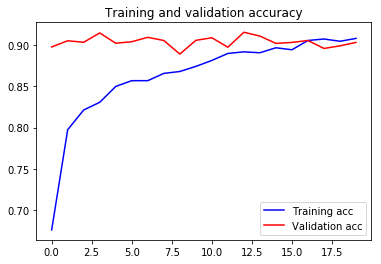

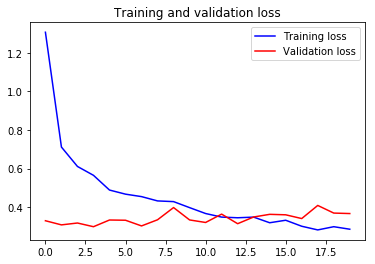

In [37]:
acc = history_df['categorical_accuracy']
val_acc = history_df['val_categorical_accuracy']
loss = history_df['loss']
val_loss = history_df['val_loss']

epochs = range(len(acc))
 
plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
 
plt.show()

### Classification via features calculated by the CNN
Gotta load an image, convert it into an array, expand its dimensions (batch number comes first) and send it through the network. Flatten the output vector and use it to classify the image.

Alternative: get the output from the softmax layer and classify that instead (meta recognition).

In [ ]:
test_img = image.load_img('data/val/10/0010.jpg', target_size=(299, 299))
test_img = image.img_to_array(test_img)

test_img /= 255
test_img = np.expand_dims(test_img, axis=0)

In [ ]:
feats = net.predict(test_img)

## Stuff left behind because reasons
Nothing useful past here

In [ ]:
# I was asked to use as metrics normalised accuracy and F1
# But since 2.0, Keras doesn't support several metrics anymore and the
# reason is sound: they were calculated batchwise instead of globally.
# The answer to this comes with the ability to define Callbacks.

class MetricsCb(Callback):
    def on_train_begin(self, logs={}):
        # define metric histories
        self.f1_samples = []
        self.nacc_samples = []
    
    def on_epoch_end(self, epoch, logs={}):
        # calculate metrics for current epoch and update history variables
        validation_preds = (np.asarray(self.model.predict(
            self.validation_data[0]))).round()
        validation_targets = self.validation_data[1]
        
        f1_value = f1_score(validation_targets, validation_preds, average='weighted')
        nacc_value = accuracy_score(validation_targets, validation_preds, normalize=True)
        
        self.f1_samples.append(f1_value)
        self.nacc_samples.append(nacc_value)
        
        print('Custom metrics over epoch %d:\tF1: %.3f\tNormalised Accuracy: %.3f' % (
            epoch, f1_value, nacc_value))

        return

metrics_cb = MetricsCb()


In [ ]:
# Manually train batch after batch because flow_from_directory does not suppost my callbacks
from keras import backend as K

class CategoricalTruePositives(keras.layers.Layer):
    """Stateful Metric to count the total true positives over all batches.

    Assumes predictions and targets of shape `(samples, 1)`.

    # Arguments
        name: String, name for the metric.
    """

    def __init__(self, name='true_positives', **kwargs):
        super(CategoricalTruePositives, self).__init__(name=name, **kwargs)
        self.stateful = True
        self.true_positives = K.variable(value=0, dtype='int32')

    def reset_states(self):
        K.set_value(self.true_positives, 0)

    def __call__(self, y_true, y_pred):
        """Computes the number of true positives in a batch.

        # Arguments
            y_true: Tensor, batch_wise labels
            y_pred: Tensor, batch_wise predictions

        # Returns
            The total number of true positives seen this epoch at the
                completion of the batch.
        """
        y_true = K.cast(y_true, 'int32')
        y_pred = K.cast(K.round(y_pred), 'int32')
        
        correct_preds = K.cast(K.equal(y_pred, y_true), 'int32')
        true_pos = K.cast(K.sum(correct_preds * y_true), 'int32')
        current_true_pos = self.true_positives * 1
        self.add_update(K.update_add(self.true_positives,
                                     true_pos),
                        inputs=[y_true, y_pred])
        return current_true_pos + true_pos


# menual example from keras
for e in range(epochs):
    print('Epoch', e)
    
    batches = 0
    
    for x_batch, y_batch in datagen.flow(x_train, y_train, batch_size=params['batch_size']):
        model.fit(x_batch, y_batch) # this runs for 1 epoch
        
        batches += 1
        
        if batches >= len(x_train) / params['batch_size']:
            # we need to break the loop by hand because
            # the generator loops indefinitely
            break

    
###################################################################################
#                               RAW CODE FOR METRICS
###################################################################################
def precision(y_true, y_pred):
    """Precision metric.
    Only computes a batch-wise average of precision.
    Computes the precision, a metric for multi-label classification of
    how many selected items are relevant.
    """
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    
    precision = true_positives / (predicted_positives + K.epsilon())
    
    return precision


def recall(y_true, y_pred):
    """Recall metric.
    Only computes a batch-wise average of recall.
    Computes the recall, a metric for multi-label classification of
    how many relevant items are selected.
    """
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    
    recall = true_positives / (possible_positives + K.epsilon())
    
    return recall


def fbeta_score(y_true, y_pred, beta=1):
    """Computes the F score.
    The F score is the weighted harmonic mean of precision and recall.
    Here it is only computed as a batch-wise average, not globally.
    This is useful for multi-label classification, where input samples can be
    classified as sets of labels. By only using accuracy (precision) a model
    would achieve a perfect score by simply assigning every class to every
    input. In order to avoid this, a metric should penalize incorrect class
    assignments as well (recall). The F-beta score (ranged from 0.0 to 1.0)
    computes this, as a weighted mean of the proportion of correct class
    assignments vs. the proportion of incorrect class assignments.
    With beta = 1, this is equivalent to a F-measure. With beta < 1, assigning
    correct classes becomes more important, and with beta > 1 the metric is
    instead weighted towards penalizing incorrect class assignments.
    """
    if beta < 0:
        raise ValueError('The lowest choosable beta is zero (only precision).')

    # If there are no true positives, fix the F score at 0 like sklearn.
    if K.sum(K.round(K.clip(y_true, 0, 1))) == 0:
        return 0

    p = precision(y_true, y_pred)
    r = recall(y_true, y_pred)
    
    bb = beta ** 2
    fbeta_score = (1 + bb) * (p * r) / (bb * p + r + K.epsilon())
    
    return fbeta_score


def fmeasure(y_true, y_pred):
    """Computes the f-measure, the harmonic mean of precision and recall.
    Here it is only computed as a batch-wise average, not globally.
    """
    return fbeta_score(y_true, y_pred, beta=1)